In [1]:

%%capture
import pandas as pd
import boto3
import io
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
from datetime import datetime, timedelta
from helpers import AWS_031_tools
from helpers import AWS_095_tools
from helpers import AWS_108_tools
from helpers import tde_sales_parse_tools
from helpers import wink_rate_wrangling_FIA
from helpers import inference_functions_FIA
from helpers import feature_engineering_functions_FIA
warnings.filterwarnings('ignore')

current_time = datetime.now()
current_date = current_time.strftime("%Y-%m-%d")
date_path = f"year={current_time.year}/month={current_time.month:02}/day={current_time.day:02}"

sns.set_theme(style="whitegrid", palette="deep")
# current_date_of_mature_data = (current_time - timedelta(days=60)).strftime("%Y-%m-%d")
current_date_of_mature_data = (current_time - timedelta(days=0)).strftime("%Y-%m-%d")

version = "v2_1"

time: 1.29 s (started: 2026-01-09 14:30:16 +00:00)


# Table of Contents
* [Section 1: Load FIA Sales Time Series](#sec1:FIA_Sales_data)
    * [Section 1.1: Load FIA Sales](#sec1_1:Load)
    * [Section 1.3: Create Sales Data Time Series](#sec1_3:ts_by_firm)
* [Section 2: Creat WINK Rate Data Time Series](#sec2:wink)
    * [Section 2.1: Load, Update and Save WINK Full Data Archive](#sec2_1:Load)
    * [Section 2.2: Filter and Organize Rates by date](#sec2_2:Filter)
    * [Section 2.3: Organize and Save](#sec2_3:Organize_save)
    * [Section 2.4: WINK Output Marketing Mix Mode](#](#sec2_4:MMM))

* [Section 3: Build Model Features](#sec3:feature_engineering)
* [Section 4: Model Training and Inference ](#sec4:inferenence)
* [Section 5: Output Visualization](#sec5:viz)


In [2]:
rate_options_C = np.linspace(-0.5, 0.5, 20 * 5 + 1)
rate_options_C

array([-0.5 , -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43, -0.42,
       -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33,
       -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24,
       -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
       -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,
        0.04,  0.05,  0.06,  0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,
        0.13,  0.14,  0.15,  0.16,  0.17,  0.18,  0.19,  0.2 ,  0.21,
        0.22,  0.23,  0.24,  0.25,  0.26,  0.27,  0.28,  0.29,  0.3 ,
        0.31,  0.32,  0.33,  0.34,  0.35,  0.36,  0.37,  0.38,  0.39,
        0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,  0.46,  0.47,  0.48,
        0.49,  0.5 ])

time: 4.37 ms (started: 2026-01-09 14:30:18 +00:00)


## Section 1: Load FIA sales data <a id="sec1:FIA_Sales_data"></a>


### Section 1.1: Load FIA sales data <a id="sec1_1:Load"></a>


In [3]:
# Load all FIA sales data from tde tables on
product_name = "PruSecure"
bucket_name = "pruvpcaws031-east-isg-ie-lake"
srcpath = "access/ierpt/tde_sales_by_product_by_fund/"
xid = "x259830"
df_PruSecure_full = AWS_031_tools.download_from_031(
    xid, srcpath, product_name, bucket_name
)
df_PruSecure = tde_sales_parse_tools.sales_cleanup(df_PruSecure_full)

# df_PruSecure = tde_sales_parse_tools.sales_cleanup(df_PruSecure_full)
df_PruSecure = df_PruSecure[
    df_PruSecure.contract_surrender_charge_ruleset.isin(["FIA5YR"])
]

df_PruSecure = df_PruSecure[df_PruSecure["firm_name"] != "J.P. Morgan Securities LLC"]

access/ierpt/tde_sales_by_product_by_fund/part-00000-aafdce77-5262-4070-8f7f-32740481aae1-c000.snappy.parquet
access/ierpt/tde_sales_by_product_by_fund/part-00001-aafdce77-5262-4070-8f7f-32740481aae1-c000.snappy.parquet
access/ierpt/tde_sales_by_product_by_fund/part-00002-aafdce77-5262-4070-8f7f-32740481aae1-c000.snappy.parquet
access/ierpt/tde_sales_by_product_by_fund/part-00003-aafdce77-5262-4070-8f7f-32740481aae1-c000.snappy.parquet
access/ierpt/tde_sales_by_product_by_fund/part-00004-aafdce77-5262-4070-8f7f-32740481aae1-c000.snappy.parquet
access/ierpt/tde_sales_by_product_by_fund/part-00005-aafdce77-5262-4070-8f7f-32740481aae1-c000.snappy.parquet
access/ierpt/tde_sales_by_product_by_fund/part-00006-aafdce77-5262-4070-8f7f-32740481aae1-c000.snappy.parquet
access/ierpt/tde_sales_by_product_by_fund/part-00007-aafdce77-5262-4070-8f7f-32740481aae1-c000.snappy.parquet
access/ierpt/tde_sales_by_product_by_fund/part-00008-aafdce77-5262-4070-8f7f-32740481aae1-c000.snappy.parquet
access/ier

### Section 1.2: Create Sales Data Time Series <a id="sec1_3:ts_by_firm"></a>


In [4]:
roll = 7
time_series_PruSecure_daily_application_signed_date = (
    df_PruSecure[["application_signed_date", "contract_initial_premium_amount"]]
    .sort_values(by="application_signed_date")
    .rename(
        columns={
            "contract_initial_premium_amount": "sales",
            "application_signed_date": "date",
        }
    )
    .groupby(pd.Grouper(key="date", freq="d"))
    .sum()
    .reset_index()
)

time_series_PruSecure_daily_application_signed_date["sales"] = (
    time_series_PruSecure_daily_application_signed_date.sales.rolling(roll).mean()
)


time_series_PruSecure_daily_contract_issue_date = (
    df_PruSecure[["contract_issue_date", "contract_initial_premium_amount"]]
    .sort_values(by="contract_issue_date")
    .rename(
        columns={
            "contract_initial_premium_amount": "sales",
            "contract_issue_date": "date",
        }
    )
    .groupby(pd.Grouper(key="date", freq="d"))
    .sum()
    .reset_index()
)

time_series_PruSecure_daily_contract_issue_date["sales"] = (
    time_series_PruSecure_daily_contract_issue_date.sales.rolling(roll).mean()
)
mask_date_app = (
    time_series_PruSecure_daily_application_signed_date["date"] > "2021-01-01"
)
mask_date_con = time_series_PruSecure_daily_contract_issue_date["date"] > "2021-01-01"

time: 14.3 ms (started: 2026-01-09 14:30:26 +00:00)


In [5]:
file_name_sales = f"FIA_{version}/PruSecure_Sales"
AWS_108_tools.save_to_s3_108(
    time_series_PruSecure_daily_application_signed_date,
    file_name=file_name_sales,
    current_date=current_date,
)

file_name_sales = f"FIA_{version}/PruSecure_Sales_contract"
AWS_108_tools.save_to_s3_108(
    time_series_PruSecure_daily_contract_issue_date.rename(
        columns={"sales": "sales_by_contract_date"}
    ),
    file_name=file_name_sales,
    current_date=current_date,
)

ANN_Price_Elasticity_Data_Science/FIA_v2_1/PruSecure_Sales_2026-01-09.parquet
ANN_Price_Elasticity_Data_Science/FIA_v2_1/PruSecure_Sales_contract_2026-01-09.parquet
time: 313 ms (started: 2026-01-09 14:30:26 +00:00)


## Section 2 Build Wink Rates <a id="sec2:wink"></a>


### Section 2.1: Load, Update and Save WINK Full Data Archive <a id="sec2_1:Load"></a>


In [6]:
# bucket_name = "cdo-annuity-364524684987-bucket"
# srcpath = "ANN_Price_Elasticity_Data_Science/WINK_archive"
# file_name = "wink_history"


# max_date_archive = AWS_108_tools.max_wink_108_archive_date(
#     path=srcpath, bucket_name=bucket_name
# )

# # max_date_archive = '2024-10-04'

# df_WINK_history_archive = AWS_108_tools.download_from_108(
#     file_name, path=srcpath, bucket_name=bucket_name, current_date=max_date_archive
# )


# bucket_name = "pruvpcaws095-use1-cdo-edp-standardized-rdh"
# srcpath = "wink/data/"
# xid = "x259830"
# df_WINK_history = AWS_095_tools.download_wink_update_from_095(
#     df_WINK_history_archive, max_date_archive, xid, srcpath, bucket_name
# )
# file_name = "WINK_archive/wink_history"
# AWS_108_tools.save_to_s3_108(
#     df_WINK_history,
#     file_name,
#     path="ANN_Price_Elasticity_Data_Science",
#     bucket_name="cdo-annuity-364524684987-bucket",
#     current_date=current_date,
# )

# # file_name = "WINK_archive/wink_history"
# # AWS_108_tools.save_to_s3_108(df_WINK_history,
# #                              file_name,3
# #                              path='ANN_Price_Elasticity_Data_Science',
# #                              bucket_name="cdo-annuity-364524684987-bucket",
# #                              current_date=current_date)

# max_date = df_WINK_history.date.max()

sts_client = boto3.client("sts", endpoint_url="https://sts.us-east-1.amazonaws.com")
assumed_role_object = sts_client.assume_role(
    RoleArn="arn:aws:iam::159058241883:role/isg-usbie-annuity-CA-s3-sharing",
    RoleSessionName="x259830",
)
credentials = assumed_role_object["Credentials"]

s3_resource = boto3.resource(
    "s3",
    aws_access_key_id=credentials["AccessKeyId"],
    aws_secret_access_key=credentials["SecretAccessKey"],
    aws_session_token=credentials["SessionToken"],
)
bucket_name = "pruvpcaws031-east-isg-ie-lake"
mybucket = s3_resource.Bucket(bucket_name)
srcpath = "access/ierpt/wink_ann_product_rates/"
# srcpath = "access/ierpt/tde_sales_by_product_by_fund/"
print(boto3.client("sts").get_caller_identity())


df_wink = pd.DataFrame()
k = 0
for obj in mybucket.objects.filter(Prefix=srcpath):
    file_name = obj.key
    print(obj.key)
    if "parquet" in file_name:
        obj = s3_resource.Object(bucket_name, file_name)
        buffer = io.BytesIO()
        obj.download_fileobj(buffer)
        df_temp = pd.read_parquet(buffer, engine="pyarrow")
        df_wink = pd.concat([df_wink, df_temp], ignore_index=True)
        print(df_temp.shape)
        k = k + df_temp.shape[0]
print(boto3.client("sts").get_caller_identity())

df_wink.to_parquet("wink_archive.parquet", engine="pyarrow")

df_wink["date"] = pd.to_datetime(df_wink["effectiveDate"])

df_WINK_history = df_wink
df_WINK_history["companyName"] = df_WINK_history.companyName.str.strip().str.lower()
df_WINK_history["productName"] = df_WINK_history.productName.str.strip().str.lower()
max_date = df_WINK_history.date.max()
max_date

{'UserId': 'AROAVJX25I25ROHPPXAI5:SageMaker', 'Account': '364524684987', 'Arn': 'arn:aws:sts::364524684987:assumed-role/cdo-annuity-exec-role/SageMaker', 'ResponseMetadata': {'RequestId': 'c11dffb4-3c41-4945-9877-528f82ec8103', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'c11dffb4-3c41-4945-9877-528f82ec8103', 'x-amz-sts-extended-request-id': 'MTp1cy1lYXN0LTE6UzoxNzY3OTY5MDI2OTkxOkc6YUQ3R1V4UXA=', 'content-type': 'text/xml', 'content-length': '446', 'date': 'Fri, 09 Jan 2026 14:30:27 GMT'}, 'RetryAttempts': 0}}
access/ierpt/wink_ann_product_rates/part-00000-896d9637-c359-4212-a352-f3db8055dee4-c000.snappy.parquet
(109316, 78)
access/ierpt/wink_ann_product_rates/part-00001-896d9637-c359-4212-a352-f3db8055dee4-c000.snappy.parquet
(109316, 78)
access/ierpt/wink_ann_product_rates/part-00002-896d9637-c359-4212-a352-f3db8055dee4-c000.snappy.parquet
(109321, 78)
access/ierpt/wink_ann_product_rates/part-00003-896d9637-c359-4212-a352-f3db8055dee4-c000.snappy.parquet
(109324, 78)


Timestamp('2026-01-05 00:00:00')

time: 16 s (started: 2026-01-09 14:30:26 +00:00)


### Section 2.2: Filter WINK Data <a id="sec2_2:Filter"></a>


In [7]:
prusecure_product_ids = {
    "AIG": [2464],
    "Athene": [1974],
    "Eagle": [2362],
    "F&G": [3049],
    "Fore": [2399],
    "Lincoln": [2292],
    "Jackson": [2224],
    "MassM": [2294],
    "Mid": [3154],
    "Nation": [2710],
    "Pacific": [2425],
    "Pru": [2187, 3349],
    "Protect": [3116],
    "SBL": [1108],
    "Symetra": [3045],
}

product_name_dict = {
    "AIG": "AIG Power Index 5 Plus Annuity",
    "Athene": "Athene Accumulator 5",
    "Eagle": "Eagle Select Focus 5 with MVA",
    "F&G": "Fidelity F&G Securebuilder 5",
    "Fore": "Forethought Foreaccumulation II Fixed Index Annuity 5-Year",
    "Lincoln": "Lincoln Optiblend 5",
    "Jackson": "Jackson Marketprotector 5 Year",
    "MassM": "MassMutual Assuranceselect 5 Pplus with MVA",
    "Mid": "MidLand Summit Edge II Fixed Index Annuity 5-year",
    "Nation": "NationWide Peak 5",
    "Pacific": "Pacific Index Edge 5-Year with MVA",
    "Pru": "Prudential PruSecure 5-Year",
    "Protect": "Protective Asset Builder II 5-Year",
    "SBL": "SBL Foundations Annuity 5",
    "Symetra": "Symetra Edge Elite Fixed Indexed Annuity 5-year",
    "top_7": "Weighted Mean By Market Share of Competitors Cap Rate",
}


columns_for_analysis = [
    "date",
    "capRate",
    "amBestRating",
    "companyName",
    "mgsvRate",
    "mva",
    "participationRate",
    "premiumBand",
    "productID",
    "productMarketStatus",
    "productName",
    "productTypeName",
    "surrChargeDuration",
]

time: 997 μs (started: 2026-01-09 14:30:42 +00:00)


In [8]:
# Filtering WINK data for PruSecure

# Only FIAs
df_WINK_history = df_WINK_history[df_WINK_history["productTypeName"] == "Fixed Indexed"]

# Only SP500 indexed funds
df_WINK_history = df_WINK_history[df_WINK_history["indexUsed"] == "S&P 500"]

# Remove for fee products, such as Allianz
df_WINK_history = df_WINK_history[df_WINK_history["annualFeeForIndexingMethod"].isna()]

# only looking at caprate products instead of participlation rates, added redudent filter
df_WINK_history = df_WINK_history[df_WINK_history["capRate"].notna()]
df_WINK_history = df_WINK_history[df_WINK_history["participationRate"] == 1.00]


#  Filter for only 5 year CDSC (no PruSecure 7)
df_WINK_history = df_WINK_history[df_WINK_history["surrChargeDuration"] == "5"]

# 1-year term credited from point to point- added with crediting bonus because of business request to add SBL
df_WINK_history = df_WINK_history[
    df_WINK_history["indexCreditingFrequency"] == "Annual"
]
df_WINK_history = df_WINK_history[df_WINK_history["indexingMethod"] == "Annual PTP"]
df_WINK_history = df_WINK_history[
    df_WINK_history["defaultActuarialView"].isin(
        [
            "Annual PTP: Annual Crediting, No Premium Bonus",
            "Annual PTP: Annual Crediting with Premium Bonus",
        ]
    )
]

#  Filter only 100k and up premium band.
# NOTE: the logic is written this way because some carriers do not have a rate band
df_WINK_history = df_WINK_history[
    ~(
        (df_WINK_history["premiumBand"] == "0")
        | (df_WINK_history["premiumBand"] == "250")
    )
]

# Filter duplicates
df_WINK_history = df_WINK_history.sort_values(
    by=["date", "capRate"], ascending=[True, False]
).drop_duplicates(subset=["date", "companyName", "productName", "productID", "mva"])

# df_WINK_history = df_WINK_history[columns_for_analysis]

time: 644 ms (started: 2026-01-09 14:30:42 +00:00)


### Section 2.3: Organize WINK Data <a id="sec2_3:Organize_save"></a>


In [9]:
%%capture
c = [
    "AIG",
    "Athene",
    "Eagle",
    "F&G",
    "Lincoln",
    "MassM",
    "Mid",
    "Nation",
    "Pacific",
    "Protect",
    "SBL",
    "Symetra",
]

rolling = 7
start_date = "2017-01-17"
df_wink_rates_roll = wink_rate_wrangling_FIA.time_series_pivot_wink(
    df_WINK_history, prusecure_product_ids, start_date, current_date, c, rolling=rolling
)


file_path = f"WINK_rate_features_archive/FIA_{version}/{date_path}"
file_name = f"WINK_competitive_landscape_FIA_1Y_term_5Y_surr_duration_rolling_{rolling}"
os.makedirs(file_path, exist_ok=True)
df_wink_rates_roll.to_csv(f"{file_path}/{file_name}.csv")
AWS_108_tools.save_to_s3_108(
    df_wink_rates_roll,
    file_name=f"{file_path}/{file_name}",
    path="ANN_Price_Elasticity_Data_Science",
    bucket_name="cdo-annuity-364524684987-bucket",
)

start_date = "2017-01-17"
df_wink_rates = wink_rate_wrangling_FIA.time_series_pivot_wink(
    df_WINK_history, prusecure_product_ids, start_date, current_date, c, rolling=1
)


file_path = f"WINK_rate_features_archive/FIA_{version}/{date_path}"
file_name = f"WINK_competitive_landscape_FIA_1Y_term_5Y_surr_duration"
os.makedirs(file_path, exist_ok=True)
df_wink_rates.to_csv(f"{file_path}/{file_name}.csv")
AWS_108_tools.save_to_s3_108(
    df_wink_rates,
    file_name=f"{file_path}/{file_name}",
    path="ANN_Price_Elasticity_Data_Science",
    bucket_name="cdo-annuity-364524684987-bucket",
)

time: 3.52 s (started: 2026-01-09 14:30:43 +00:00)


### Section 2.4: WINK Output for Marketing Mix Model  <a id="sec2_4:MMM"></a>


In [10]:
agg_dict = {"Pru": "mean", "top_7": "mean"}
df_MMM_weekly = (
    df_wink_rates.groupby(pd.Grouper(key="date", freq="W")).agg(agg_dict).reset_index()
)

df_MMM_weekly = (
    df_MMM_weekly[["date", "Pru", "top_7"]]
    .rename(
        columns={
            "Pru": "Prudential_PruSecure_Caprate",
            "top_7": "Competitor_of_PruSecure_Mean_Caprate",
        }
    )
    .dropna()
    .reset_index(drop=True)
)
df_MMM_weekly.to_csv(f"MMM_data/PruSecure_Caprates_for_MMM_{current_date}.csv")
df_MMM_weekly

,date,Prudential_PruSecure_Caprate,Competitor_of_PruSecure_Mean_Caprate
0,2018-02-04,5.15,4.125000
1,2018-02-11,5.15,4.125000
2,2018-02-18,5.15,4.125000
3,2018-02-25,5.15,4.125000
4,2018-03-04,5.15,4.339286
...,...,...,...
410,2025-12-14,9.50,9.357143
411,2025-12-21,9.50,9.295918
412,2025-12-28,9.50,9.285714
413,2026-01-04,9.50,9.326531


time: 19.6 ms (started: 2026-01-09 14:30:47 +00:00)


## Section 3: Build Model Features <a id="sec3:feature_engineering"></a>


In [11]:
file_name_dgs5 = "MACRO_ECONOMIC_DATA/DGS5_index"
file_name_CPI = "MACRO_ECONOMIC_DATA/cpi_scaled"
file_path = f"WINK_rate_features_archive/FIA_{version}/{date_path}"
file_name = f"WINK_competitive_landscape_FIA_1Y_term_5Y_surr_duration_rolling_{rolling}"
file_name_sales = f"FIA_{version}/PruSecure_Sales"
file_name_contract = f"FIA_{version}/PruSecure_Sales_contract"

df_rates = AWS_108_tools.download_from_108(file_name=f"{file_path}/{file_name}")

df_DGS5 = AWS_108_tools.download_from_108(file_name=file_name_dgs5)

df_sales = AWS_108_tools.download_from_108(
    file_name=file_name_sales, current_date=current_date
)

df_CPI = AWS_108_tools.download_from_108(file_name=file_name_CPI)

df_sales_contract = AWS_108_tools.download_from_108(
    file_name=file_name_contract, current_date=current_date
)

time: 1.06 s (started: 2026-01-09 14:30:47 +00:00)


In [12]:
start_date = "2020-02-01"
end_date = current_time.strftime("%Y-%m-%d")
df_sales_cpi_adj = feature_engineering_functions_FIA.cpi_adjustment(
    data=df_sales,
    df_DGS5=df_DGS5,
    cpi_data=df_CPI,
    df_contract=df_sales_contract,
    start_date=start_date,
    end_date=end_date,
)
df_ts = df_rates.merge(df_sales_cpi_adj, on="date").drop_duplicates()

rolling = 1
df_ts_weekly = feature_engineering_functions_FIA.time_series_week_agg_smoothed(
    df_ts, rolling
)
df_ts_weekly_w_lag = feature_engineering_functions_FIA.create_lag_features(df_ts_weekly)

mask_time = df_ts_weekly_w_lag["date"] > pd.to_datetime("2022-01-01")
df_weekly = df_ts_weekly_w_lag[mask_time]
df_weekly = df_weekly[sorted(df_weekly.columns)].reset_index(drop=True)


df_weekly["day_of_year"] = df_weekly.date.dt.day_of_year
mask_holiday = (df_weekly["day_of_year"] < 14) | (df_weekly["day_of_year"] > 360)
df_weekly["holiday"] = mask_holiday
df_weekly["holiday"] = df_weekly["holiday"].astype("int")

time: 221 ms (started: 2026-01-09 14:30:48 +00:00)


In [13]:
file_path = f"FIA_{version}/features/{date_path}/"
file_name = f"FIA_final_data_set"

os.makedirs(file_path, exist_ok=True)
df_weekly.to_csv(f"{file_path}/{file_name}.csv")
AWS_108_tools.save_to_s3_108(
    df_weekly,
    file_name=f"{file_path}/{file_name}",
    path="ANN_Price_Elasticity_Data_Science",
    bucket_name="cdo-annuity-364524684987-bucket",
)

ANN_Price_Elasticity_Data_Science/FIA_v2_1/features/year=2026/month=01/day=09//FIA_final_data_set.parquet
time: 336 ms (started: 2026-01-09 14:30:48 +00:00)


## Section 4: Model Training and Inference <a id="sec4:inferenence"></a>


In [14]:
file_path = f"FIA_{version}/features/{date_path}/"
file_name = f"FIA_final_data_set"

df_FIA = AWS_108_tools.download_from_108(file_name=f"{file_path}/{file_name}")
df_FIA["date"] = pd.to_datetime(df_FIA["date"])

time: 172 ms (started: 2026-01-09 14:30:48 +00:00)


In [15]:
file_path = f"WINK_rate_features_archive/FIA_{version}/{date_path}"
file_name = f"WINK_competitive_landscape_FIA_1Y_term_5Y_surr_duration"

df_rates = AWS_108_tools.download_from_108(file_name=f"{file_path}/{file_name}")

time: 157 ms (started: 2026-01-09 14:30:48 +00:00)


In [16]:
target_variable = "sales_logit_forward_1"

features = [
    "C_diff_top_seven_lag_5",
    "C_mid_lag_5",
    "DGS5_lag_5",
    "P_lag_4",
    "P_lag_3",
    "P_lag_0",
]
n_estimators = 100

baseline_forecast, trained_model = inference_functions_FIA.center_baseline(
    df_FIA,
    df_rates,
    features,
    target_variable,
    current_date_of_mature_data,
    n_estimators,
)

time: 323 ms (started: 2026-01-09 14:30:48 +00:00)


In [17]:
df_merge = pd.DataFrame()
rate_options = np.linspace(-1, 1, 5 + 1)
rate_options_C = np.linspace(-0.5, 0.5, 5 + 1)
# rate_options_C = np.array([0])

for C_rate in rate_options_C:
    print(f"{int(np.round(100*C_rate)):d}bps")

    df_dollars, df_pct_change = inference_functions_FIA.rate_adjustments(
        df_FIA,
        df_rates,
        rate_options,
        baseline_forecast,
        trained_model,
        features,
        C_rate,
    )

    df_output_pct = inference_functions_FIA.confidence_interval(
        df_pct_change, rate_options
    )
    df_output_dollar = inference_functions_FIA.confidence_interval(
        df_dollars, rate_options
    )

    df_num = df_output_dollar.melt(id_vars=["rate_change_in_basis_points"]).rename(
        columns={"variable": "range", "value": "dollar"}
    )
    df_pct = df_output_pct.melt(id_vars=["rate_change_in_basis_points"]).rename(
        columns={"variable": "range", "value": "pct_change"}
    )

    df_to_bi = df_num.merge(
        df_pct[["rate_change_in_basis_points", "range", "pct_change"]],
        on=["rate_change_in_basis_points", "range"],
    )
    df_to_bi_melt = inference_functions_FIA.melt_dataframe_for_tableau(
        df_to_bi, df_FIA, current_date
    )
    df_to_bi_melt["product"] = "PruSecure"
    df_to_bi_melt["Synthetic Competitor"] = (
        0.5
        * (
            df_rates["third_highest_benefit"].iloc[-1]
            + df_rates["second_highest_benefit"].iloc[-1]
        )
        + C_rate
    )
    df_to_bi_melt["Weighted Mean By Market Share of Competitors Cap Rate"] = 0.5 * (
        df_rates["third_highest_benefit"].iloc[-1]
        + df_rates["second_highest_benefit"].iloc[-1]
    )
    df_merge = pd.concat([df_merge, df_to_bi_melt])

-50bps
-30bps
-10bps
10bps
30bps
50bps
time: 4.68 s (started: 2026-01-09 14:30:49 +00:00)


In [18]:
mask = (
    df_merge["Synthetic Competitor"]
    == df_merge["Weighted Mean By Market Share of Competitors Cap Rate"]
)
df_merge["default_synthetic_competitor"] = 0
df_merge.loc[mask, "default_synthetic_competitor"] = 1
df_merge["default_synthetic_competitor"].sum()


df_merge["Synthetic Competitor"] = np.round(df_merge["Synthetic Competitor"], 2)
df_merge["Weighted Mean By Market Share of Competitors Cap Rate"] = np.round(
    df_merge["Weighted Mean By Market Share of Competitors Cap Rate"], 2
)

time: 2.25 ms (started: 2026-01-09 14:30:54 +00:00)


In [19]:
df_merge[df_merge["default_synthetic_competitor"] == 1]

,rate_change_in_basis_points,range,output_type,value,prediction_date,Prudential Cap Rate,Weighted Mean By Market Share of Competitors Cap Rate,Previous Two Week Sales,product,Synthetic Competitor,default_synthetic_competitor


time: 5 ms (started: 2026-01-09 14:30:54 +00:00)


In [20]:
competitor_list = [
    "AIG",
    "Athene",
    "Eagle",
    "F&G",
    "Lincoln",
    "MassM",
    "Mid",
    "Nation",
    "Pacific",
    "Pru",
    "Protect",
    "SBL",
    "Symetra",
    "top_7",
]
df_merge["version"] = version.replace("_", ".").replace("v", "")
for competitor in competitor_list:
    df_merge[product_name_dict[competitor]] = df_rates[competitor].iloc[-1]
df_FIA_run = df_merge
# df_FIA_run = df_merge
df_FIA_run["prediction_date"] = pd.to_datetime(df_FIA_run["prediction_date"])
df_FIA_run["Synthetic Competitor"].unique()

array([ 9.12,  9.32,  9.52,  9.72,  9.92, 10.12])

time: 8.03 ms (started: 2026-01-09 14:30:54 +00:00)


In [21]:
df_FIA_run[df_FIA_run["default_synthetic_competitor"] == 1]


sorted(df_FIA_run.iloc[:, :12].columns)


df_FIA_run.iloc[:, :12].info()

<class 'pandas.core.frame.DataFrame'>
Index: 216 entries, 0 to 35
Data columns (total 12 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   rate_change_in_basis_points                            216 non-null    int64         
 1   range                                                  216 non-null    object        
 2   output_type                                            216 non-null    object        
 3   value                                                  216 non-null    float64       
 4   prediction_date                                        216 non-null    datetime64[ns]
 5   Prudential Cap Rate                                    216 non-null    float64       
 6   Weighted Mean By Market Share of Competitors Cap Rate  216 non-null    float64       
 7   Previous Two Week Sales                                216 non-null    int64 

In [22]:
file_path = f"annuities/price_elasticity/FIA/model_output/{date_path}"
file_name = f"model_ouput"
AWS_108_tools.save_to_s3_108(
    df_to_bi_melt,
    file_name=f"{file_path}/{file_name}",
    path="ANN_Price_Elasticity_Data_Science",
    bucket_name="cdo-annuity-364524684987-bucket",
)

ANN_Price_Elasticity_Data_Science/annuities/price_elasticity/FIA/model_output/year=2026/month=01/day=09/model_ouput.parquet
time: 158 ms (started: 2026-01-09 14:30:54 +00:00)


In [23]:
# sts_client = boto3.client("sts", endpoint_url="https://sts.us-east-1.amazonaws.com")
# assumed_role_object = sts_client.assume_role(
#     RoleArn="arn:aws:iam::668382231790:role/cdo-annuity-CA-s3-sharing",
#     RoleSessionName="x259830",
# )
# credentials = assumed_role_object["Credentials"]

# bucket_name = "pruvpcaws095-use1-cdo-edp-cust360-inference"
# s3_client = boto3.client(
#     "s3",
#     aws_access_key_id=credentials["AccessKeyId"],
#     aws_secret_access_key=credentials["SecretAccessKey"],
#     aws_session_token=credentials["SessionToken"],
# )
# for date in pd.to_datetime(df_FIA_run["prediction_date"].unique()):
#     print(date)
#     mask_date = df_FIA_run["prediction_date"] == date
#     day = date.day
#     month = date.month
#     year = date.year

#     df_temp = df_FIA_run[mask_date]
#     df_temp["prediction_date"] = df_temp.prediction_date.dt.strftime("%Y-%m-%d")

#     prefix = f"annuities/price_elasticity/model_output/FIA/year={year}/month={month:02}/day={day:02}/"
#     print(prefix)
#     buffer = io.BytesIO()
#     df_temp.to_parquet(buffer, engine="pyarrow")
#     buffer.seek(0)
#     s3_client.upload_fileobj(buffer, bucket_name, prefix + "model_ouput.parquet")

time: 587 μs (started: 2026-01-09 14:30:54 +00:00)


In [24]:
# df_monitoring = inference_functions_FIA.model_monitoring(df_FIA,
#                                                          current_date_of_mature_data,
#                                                          features,
#                                                         version)
# dates = df_monitoring['prediction_date'].unique()


# sts_client = boto3.client('sts', endpoint_url='https://sts.us-east-1.amazonaws.com')
# assumed_role_object=sts_client.assume_role(
#     RoleArn="arn:aws:iam::668382231790:role/cdo-annuity-CA-s3-sharing", # Insert the IAM role ARN in the target account provided to you. e.g. arn:aws:iam::777228421253:role/cd-edp-source-cross-account-Role-VC0GKZ47NOFL
#     RoleSessionName="x259830"
# )
# credentials=assumed_role_object['Credentials']

# bucket_name = "pruvpcaws095-use1-cdo-edp-cust360-inference"
# s3_client = boto3.client('s3', aws_access_key_id=credentials['AccessKeyId'],
#                                 aws_secret_access_key=credentials['SecretAccessKey'],
#                                 aws_session_token=credentials['SessionToken'])


# for date in dates:
#     mask_date = df_monitoring['prediction_date']==date
#     day = date.day
#     month = date.month
#     year = date.year


#     df_temp = df_monitoring[mask_date]
#     df_temp['prediction_date'] = df_temp.prediction_date.dt.strftime('%Y-%m-%d')


#     prefix = f"annuities/price_elasticity/model_output/FIA_model_monitoring/year={year}/month={month:02}/day={day:02}/"
#     print(prefix)

#     buffer = io.BytesIO()
#     df_temp.to_parquet(buffer, engine="pyarrow")
#     buffer.seek(0)
#     s3_client.upload_fileobj(buffer, bucket_name, prefix+'model_ouput.parquet')

time: 842 μs (started: 2026-01-09 14:30:54 +00:00)


## Section 5: Output Visualization <a id="sec5:viz"></a>
### NOTE- this code is a mess and be cleaned up someday, but the only purpose is to create the plots I use for my own reference

In [25]:
rate_options_C = np.array([0])

for C_rate in rate_options_C:
    print(f"{int(np.round(100*C_rate)):d}bps")

    df_dollars, df_pct_change = inference_functions_FIA.rate_adjustments(
        df_FIA,
        df_rates,
        rate_options,
        baseline_forecast,
        trained_model,
        features,
        C_rate,
    )

    df_output_pct = inference_functions_FIA.confidence_interval(
        df_pct_change, rate_options
    )
    df_output_dollar = inference_functions_FIA.confidence_interval(
        df_dollars, rate_options
    )

    df_num = df_output_dollar.melt(id_vars=["rate_change_in_basis_points"]).rename(
        columns={"variable": "range", "value": "dollar"}
    )
    df_pct = df_output_pct.melt(id_vars=["rate_change_in_basis_points"]).rename(
        columns={"variable": "range", "value": "pct_change"}
    )

    df_to_bi = df_num.merge(
        df_pct[["rate_change_in_basis_points", "range", "pct_change"]],
        on=["rate_change_in_basis_points", "range"],
    )
    df_to_bi_melt = inference_functions_FIA.melt_dataframe_for_tableau(
        df_to_bi, df_FIA, current_date
    )
    df_to_bi_melt["product"] = "PruSecure"
    df_to_bi_melt["Synthetic Competitor"] = (
        0.5
        * (
            df_rates["third_highest_benefit"].iloc[-1]
            + df_rates["second_highest_benefit"].iloc[-1]
        )
        + C_rate
    )
    df_merge = pd.concat([df_merge, df_to_bi_melt])
df = df_FIA

0bps
time: 785 ms (started: 2026-01-09 14:30:54 +00:00)


In [27]:
df_pct_change.to_csv(f"BI_TEAM/weekly_raw_bootstrap_{current_date}.csv")

df_pct_change["output_type"] = "pct_change"
df_pct_change = df_pct_change.reset_index().rename(columns={"index": "simulation_run"})

df_dollars["output_type"] = "dollars"
df_dollars = df_dollars.reset_index().rename(columns={"index": "simulation_run"})
dr = pd.concat([df_pct_change, df_dollars])
dr["prediction_date"] = current_time
dr.to_csv(
    f"BI_TEAM/price_elasticity_PruSecure_bootstrap_distributions_{current_date}.csv"
)

df_bootstrap = df_dollars.melt(id_vars=["simulation_run", "output_type"])
df_bootstrap["variable"] = 100 * df_bootstrap["variable"]
df_bootstrap = df_bootstrap.rename(columns={"variable": "rate_change_in_basis_points"})
df_bootstrap["prediction_date"] = current_time

df_bootstrap.to_csv(
    f"BI_TEAM/price_elasticity_PruSecure_bootstrap_distributions_melt_dollars_{current_date}.csv"
)

df_bootstrap = df_pct_change.melt(id_vars=["simulation_run", "output_type"])
df_bootstrap["variable"] = 100 * df_bootstrap["variable"]
df_bootstrap = df_bootstrap.rename(columns={"variable": "rate_change_in_basis_points"})
df_bootstrap["prediction_date"] = current_date
df_bootstrap.to_csv(
    f"BI_TEAM/price_elasticity_PruSecure_bootstrap_distributions_melt_{current_date}.csv"
)


df_output = pd.DataFrame(
    np.zeros((len(rate_options), 4)), columns=["rate_change", "bottom", "median", "top"]
)
df_output["rate_change"] = rate_options
df_output["bottom"] = np.round(
    np.quantile(df_pct_change.iloc[:, 1:-1], 0.025, axis=0), 3
)
df_output["median"] = np.round(
    np.quantile(df_pct_change.iloc[:, 1:-1], 0.50, axis=0), 3
)
df_output["top"] = np.round(np.quantile(df_pct_change.iloc[:, 1:-1], 0.975, axis=0), 3)
df_output["rate_change_in_basis_points"] = (
    np.round(df_output["rate_change"] * 100)
).astype("int")
df_output = df_output.drop(columns="rate_change")
df_output["prediction_date"] = current_date

df_output.to_csv(
    f"BI_TEAM/sample_price_elasticity_PruSecure_output_simple_pct_change_confidence_intervals_{current_date}.csv"
)
df_output_pct = df_output.drop(columns="prediction_date")

df_output = pd.DataFrame(
    np.zeros((len(rate_options), 4)), columns=["rate_change", "bottom", "median", "top"]
)
df_output["rate_change"] = rate_options
df_output["bottom"] = np.round(
    np.quantile(df_dollars.iloc[:, 1:-1], 0.025, axis=0), 0
).astype("int")
df_output["median"] = np.round(
    np.quantile(df_dollars.iloc[:, 1:-1], 0.50, axis=0), 0
).astype("int")
df_output["top"] = np.round(
    np.quantile(df_dollars.iloc[:, 1:-1], 0.975, axis=0), 0
).astype("int")
df_output["rate_change_in_basis_points"] = (
    np.round(df_output["rate_change"] * 100)
).astype("int")
df_output = df_output.drop(columns="rate_change")
df_output["prediction_date"] = current_date
df_output.to_csv(
    f"BI_TEAM/sample_price_elasticity_PruSecure_output_simple_amount_in_dollars_confidence_intervals_{current_date}.csv"
)
df_output_dollar = df_output.drop(columns="prediction_date")

df_num = df_output_dollar.melt(id_vars=["rate_change_in_basis_points"]).rename(
    columns={"variable": "range", "value": "dollar"}
)
df_pct = df_output_pct.melt(id_vars=["rate_change_in_basis_points"]).rename(
    columns={"variable": "range", "value": "pct_change"}
)

df_to_bi = df_num.merge(
    df_pct[["rate_change_in_basis_points", "range", "pct_change"]],
    on=["rate_change_in_basis_points", "range"],
)


df_to_bi.to_csv(
    f"BI_TEAM/price_elasticity_PruSecure_confidence_intervals_{current_date}.csv"
)
df_to_bi_melt = df_to_bi.melt(id_vars=["rate_change_in_basis_points", "range"]).rename(
    columns={"variable": "output_type"}
)
df_to_bi_melt["prediction_date"] = current_date
df_to_bi_melt["Prudential Cap Rate"] = df["P_lag_0"].iloc[-1]
df_to_bi_melt["Weighted Mean By Market Share of Competitors Cap Rate"] = df[
    "C_lag_0"
].iloc[-1]
df_to_bi_melt["Previous Two Week Sales"] = int(
    np.round((df["sales_lag_2"].iloc[-1] + df["sales_lag_1"].iloc[-1]), -7)
)

df_to_bi_melt.to_csv(
    f"BI_TEAM/price_elasticity_PruSecure_confidence_intervals_melt_{current_date}.csv"
)

time: 40.8 ms (started: 2026-01-09 14:31:26 +00:00)


In [28]:
df_dist = pd.read_csv(
    f"BI_TEAM/price_elasticity_PruSecure_bootstrap_distributions_melt_{current_date}.csv",
    index_col=0,
)
df_dist["rate_change_in_basis_points"] = np.round(
    df_dist.rate_change_in_basis_points
).astype("int")
df_dist = df_dist[df_dist["output_type"] == "pct_change"]
df_dist["value"] = df_dist["value"]

x_labels_1 = sorted(df_dist["rate_change_in_basis_points"].unique())
x_labels = [str(int(np.round(x))) + "bps" for x in x_labels_1]
df_dist["rate_change_in_basis_points"] = (
    df_dist["rate_change_in_basis_points"].astype("string") + "bps"
)

df_dist["rate_change_in_basis_points"] = pd.Categorical(
    df_dist["rate_change_in_basis_points"], x_labels
)

df_ci = pd.read_csv(
    f"BI_TEAM/price_elasticity_PruSecure_confidence_intervals_melt_{current_date}.csv",
    index_col=0,
)
df_ci = df_ci[df_ci["output_type"] == "pct_change"]
df_ci["value"] = df_ci["value"]
df_ci["rate_change_in_basis_points"] = (
    df_ci["rate_change_in_basis_points"].astype("string") + "bps"
)
df_ci["rate_change_in_basis_points"] = pd.Categorical(
    df_ci["rate_change_in_basis_points"], x_labels
)


df_ci_columns = pd.read_csv(
    f"BI_TEAM/sample_price_elasticity_PruSecure_output_simple_pct_change_confidence_intervals_{current_date}.csv",
    index_col=0,
)
# df_ci_columns['rate_change_in_basis_points'] = 100*df_ci_columns['rate_change']
# df_ci_columns = df_ci_columns.drop(columns='rate_change')
df_ci_columns[["bottom", "median", "top"]] = df_ci_columns[["bottom", "median", "top"]]
df_ci_columns[["rate_change_in_basis_points", "bottom", "median", "top"]]

df_ci_columns["rate_change_in_basis_points"] = (
    df_ci_columns["rate_change_in_basis_points"].astype("int").astype("string") + "bps"
)
df_ci_columns["rate_change_in_basis_points"] = pd.Categorical(
    df_ci_columns["rate_change_in_basis_points"], x_labels
)

y_ticks = np.linspace(-20, 20, 9).astype("int")
y_labels = [f"{y_grid:d}%" for y_grid in y_ticks]

time: 13.6 ms (started: 2026-01-09 14:31:27 +00:00)


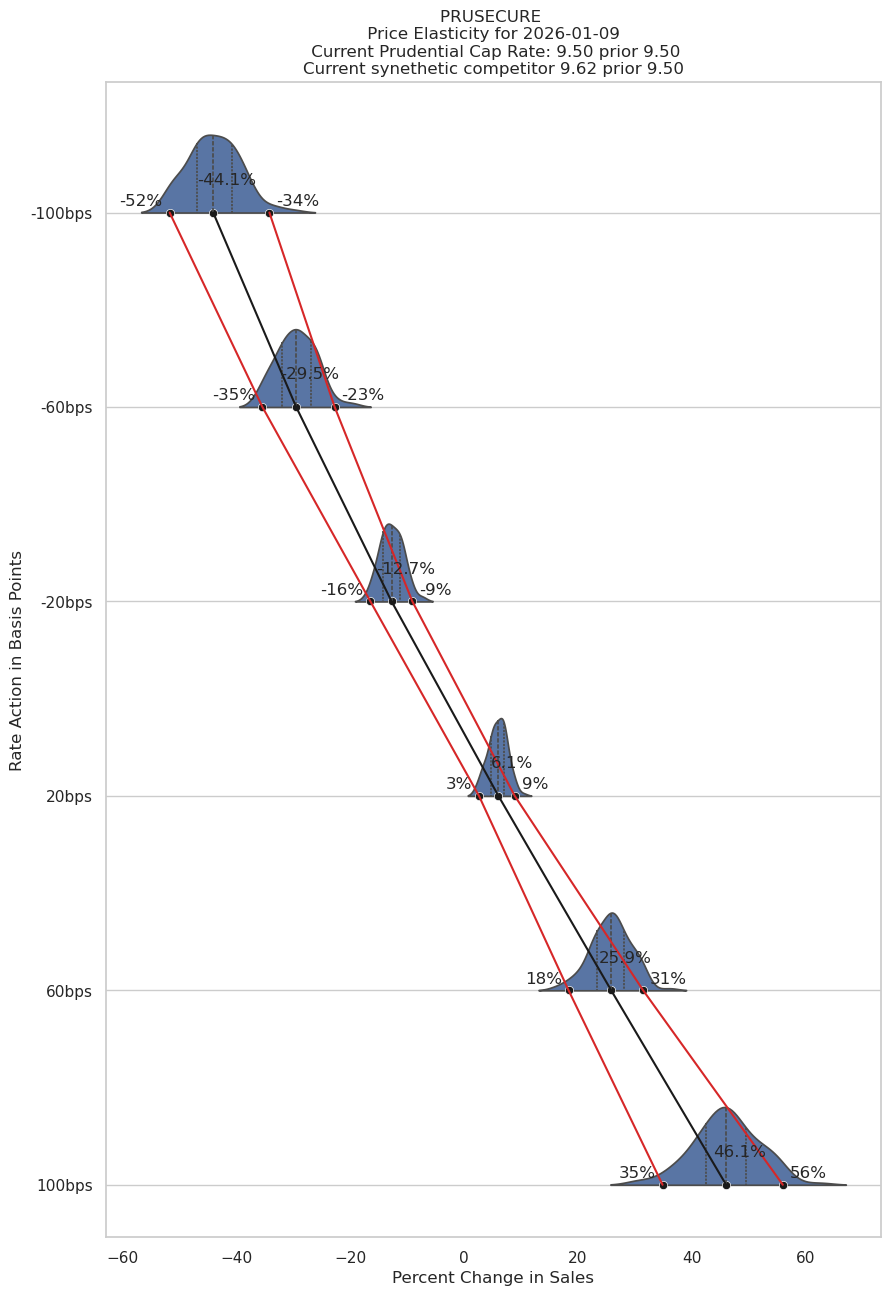

time: 561 ms (started: 2026-01-09 14:31:28 +00:00)


In [29]:
figure, axes = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(10, 15))
P = np.round(df["P_lag_0"].iloc[-1], 2)
P_lag = np.round(df["P_lag_2"].iloc[-1], 2)

C = np.round(df["C_mid_lag_0"].iloc[-1], 2)
C_lag = np.round(df["C_mid_lag_2"].iloc[-1], 2)

y_ticks = np.linspace(-25, 25, 11).astype("int")
# y_ticks = np.linspace(-15, 15, 7).astype('int')

y_labels = [f"{y_grid:d}%" for y_grid in y_ticks]
sns.set_theme(style="whitegrid", palette="deep")

sns.violinplot(
    df_dist,
    y="rate_change_in_basis_points",
    x="value",
    hue=True,
    hue_order=[True, False],
    split=True,
    dodge=True,
    density_norm="width",
    ax=axes,
    inner="quartile",
    legend=False,
)
sns.scatterplot(df_ci, y="rate_change_in_basis_points", x="value", color="k", ax=axes)
sns.lineplot(
    df_ci_columns,
    y="rate_change_in_basis_points",
    x="bottom",
    ax=axes,
    color="tab:red",
    orient="y",
)
sns.lineplot(
    df_ci_columns,
    y="rate_change_in_basis_points",
    x="median",
    ax=axes,
    color="k",
    orient="y",
)
sns.lineplot(
    df_ci_columns,
    y="rate_change_in_basis_points",
    x="top",
    ax=axes,
    color="tab:red",
    orient="y",
)
axes.set_title(
    f"PRUSECURE \n Price Elasticity for {current_date} \n Current Prudential Cap Rate: {P:.2f} prior {P_lag:.2f}\nCurrent synethetic competitor {C:.2f} prior {C_lag:.2f}"
)
# axes.set_xticks(ticks=y_ticks, labels=y_labels, rotation=40)
# axes.set_xticks(rotation=40)

axes.set_yticks(ticks=x_labels, labels=x_labels)
axes.set_xlabel("Percent Change in Sales")
axes.set_ylabel("Rate Action in Basis Points")


xs = df_ci_columns["bottom"]
ys = df_ci_columns["rate_change_in_basis_points"]
for x, y in zip(xs, ys):
    # if y=='0bps':
    #     continue
    label = f"{int(np.round(x)):d}%"

    # label = f"{np.round(x, 1):.1f}%"

    plt.annotate(
        label,  # this is the text
        (x, y),  # these are the coordinates to position the label
        textcoords="offset points",  # how to position the text
        xytext=(-5, 5),  # distance from text to points (x,y)
        ha="right",
    )  # horizontal alignment can be left, right or center


xs = df_ci_columns["median"]

for x, y in zip(xs, ys):
    # if y=='0bps':
    #     continue
    label = f"{int(np.round(x)):d}%"
    label = f"{np.round(x, 1):.1f}%"

    plt.annotate(
        label,  # this is the text
        (x, y),  # these are the coordinates to position the label
        textcoords="offset points",  # how to position the text
        xytext=(10, 20),  # distance from text to points (x,y)
        ha="center",
    )  # horizontal alignment can be left, right or center

xs = df_ci_columns["top"]

for x, y in zip(xs, ys):
    # if y=='0bps':
    #     continue
    label = f"{int(np.round(x)):d}%"

    # label = f"{np.round(x, 1):.1f}%"

    plt.annotate(
        label,  # this is the text
        (x, y),  # these are the coordinates to position the label
        textcoords="offset points",  # how to position the text
        xytext=(5, 5),  # distance from text to points (x,y)
        ha="left",
    )  # horizontal alignment can be left, right or center

# axes.get_legend().remove()
axes.grid()
plt.show()

figure.savefig(f"BI_TEAM/price_elasticity_PruSecure_Sample_{current_date}.png")

In [30]:
df_dist = pd.read_csv(
    f"BI_TEAM/price_elasticity_PruSecure_bootstrap_distributions_melt_dollars_{current_date}.csv",
    index_col=0,
)
df_dist["rate_change_in_basis_points"] = np.round(
    df_dist.rate_change_in_basis_points
).astype("int")
df_dist = df_dist[df_dist["output_type"] == "dollars"]
df_dist["value"] = df_dist["value"]

x_labels_1 = sorted(df_dist["rate_change_in_basis_points"].unique())
x_labels = [str(x) + "bps" for x in x_labels_1]
df_dist["rate_change_in_basis_points"] = (
    df_dist["rate_change_in_basis_points"].astype("string") + "bps"
)

df_dist["rate_change_in_basis_points"] = pd.Categorical(
    df_dist["rate_change_in_basis_points"], x_labels
)

df_ci = pd.read_csv(
    f"BI_TEAM/price_elasticity_PruSecure_confidence_intervals_melt_{current_date}.csv",
    index_col=0,
)
df_ci = df_ci[df_ci["output_type"] == "dollar"]
df_ci["value"] = df_ci["value"]
df_ci["rate_change_in_basis_points"] = (
    df_ci["rate_change_in_basis_points"].astype("string") + "bps"
)
df_ci["rate_change_in_basis_points"] = pd.Categorical(
    df_ci["rate_change_in_basis_points"], x_labels
)


df_ci_columns = pd.read_csv(
    f"BI_TEAM/sample_price_elasticity_PruSecure_output_simple_amount_in_dollars_confidence_intervals_{current_date}.csv",
    index_col=0,
)
# df_ci_columns['rate_change_in_basis_points'] = 100*df_ci_columns['rate_change']
# df_ci_columns = df_ci_columns.drop(columns='rate_change')
df_ci_columns[["bottom", "median", "top"]] = df_ci_columns[["bottom", "median", "top"]]
df_ci_columns[["rate_change_in_basis_points", "bottom", "median", "top"]]

df_ci_columns["rate_change_in_basis_points"] = (
    df_ci_columns["rate_change_in_basis_points"].astype("int").astype("string") + "bps"
)
df_ci_columns["rate_change_in_basis_points"] = pd.Categorical(
    df_ci_columns["rate_change_in_basis_points"], x_labels
)

# y_ticks = np.linspace(-20, 20, 9).astype('int')
# y_labels = [f"{y_grid:d}%" for y_grid in y_ticks]

time: 13.9 ms (started: 2026-01-09 14:31:28 +00:00)


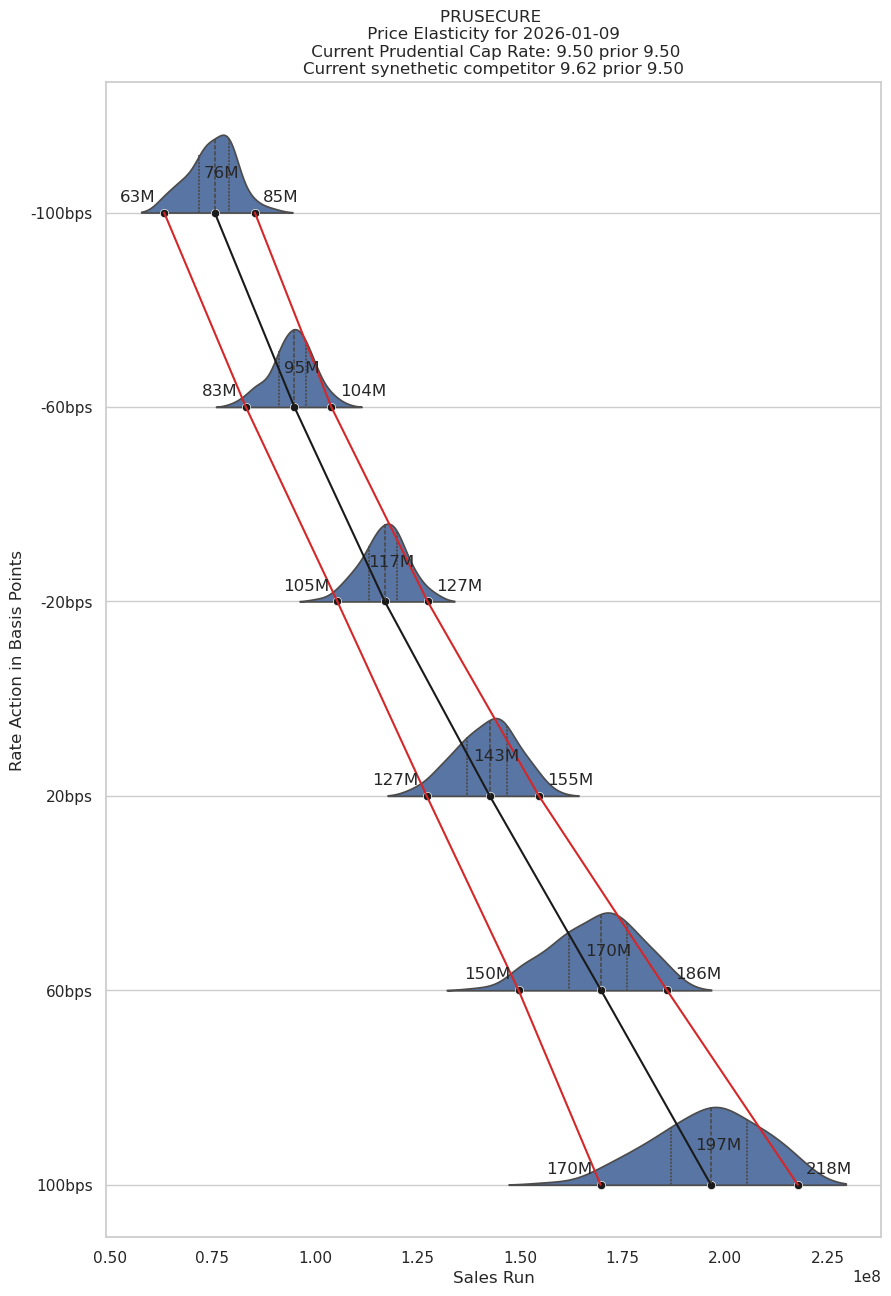

time: 535 ms (started: 2026-01-09 14:31:28 +00:00)


In [31]:
figure, axes = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(10, 15))
y_ticks = np.linspace(-20, 20, 9)
# y_ticks = np.linspace(130e6, 250e6, 8)


y_labels = [f"${int(np.round(y_grid/1e6)):d}M" for y_grid in y_ticks]
sns.set_theme(style="whitegrid", palette="deep")

sns.violinplot(
    df_dist,
    y="rate_change_in_basis_points",
    x="value",
    hue=True,
    hue_order=[True, False],
    split=True,
    dodge=True,
    density_norm="width",
    ax=axes,
    inner="quartile",
    legend=False,
)
sns.scatterplot(df_ci, y="rate_change_in_basis_points", x="value", color="k", ax=axes)
sns.lineplot(
    df_ci_columns,
    y="rate_change_in_basis_points",
    x="bottom",
    ax=axes,
    color="tab:red",
    orient="y",
)
sns.lineplot(
    df_ci_columns,
    y="rate_change_in_basis_points",
    x="median",
    ax=axes,
    color="k",
    orient="y",
)
sns.lineplot(
    df_ci_columns,
    y="rate_change_in_basis_points",
    x="top",
    ax=axes,
    color="tab:red",
    orient="y",
)
axes.set_title(
    f"PRUSECURE \n Price Elasticity for {current_date} \n Current Prudential Cap Rate: {P:.2f} prior {P_lag:.2f}\nCurrent synethetic competitor {C:.2f} prior {C_lag:.2f}"
)
# axes.set_xticks(ticks=y_ticks, labels=y_labels, rotation=40)
axes.set_yticks(ticks=x_labels, labels=x_labels)
axes.set_xlabel("Sales Run")
axes.set_ylabel("Rate Action in Basis Points")

xs = df_ci_columns["bottom"]
ys = df_ci_columns["rate_change_in_basis_points"]
for x, y in zip(xs, ys):
    label = f"{int(np.round(x/1e6)):d}M"

    # label = f"{np.round(x/1e6, 2):.2f}B"

    plt.annotate(
        label,  # this is the text
        (x, y),  # these are the coordinates to position the label
        textcoords="offset points",  # how to position the text
        xytext=(-6, 8),  # distance from text to points (x,y)
        ha="right",
    )  # horizontal alignment can be left, right or center


xs = df_ci_columns["median"]

for x, y in zip(xs, ys):

    label = f"{int(np.round(x/1e6)):d}M"
    # label = f"{np.round(x/1e6, 2):.2f}B"

    plt.annotate(
        label,  # this is the text
        (x, y),  # these are the coordinates to position the label
        textcoords="offset points",  # how to position the text
        xytext=(5, 25),  # distance from text to points (x,y)
        ha="center",
    )  # horizontal alignment can be left, right or center

xs = df_ci_columns["top"]

for x, y in zip(xs, ys):
    label = f"{int(np.round(x/1e6)):d}M"

    # label = f"{np.round(x/1e6, 2):.2f}B"

    plt.annotate(
        label,  # this is the text
        (x, y),  # these are the coordinates to position the label
        textcoords="offset points",  # how to position the text
        xytext=(6, 8),  # distance from text to points (x,y)
        ha="left",
    )  # horizontal alignment can be left, right or center

# axes.get_legend().remove()
axes.grid()
plt.show()

figure.savefig(f"BI_TEAM/price_elasticity_PruSecure_Dollars_Sample_{current_date}.png")